In [42]:
using CSV, DataFrames
using FileIO, Dates
using PyCall
using DelimitedFiles
using CairoMakie

include("./src/cubes.jl")
include("./src/motifs_analysis.jl")

@pyimport powerlaw as powlaw
so = pyimport("scipy.optimize")

PyObject <module 'scipy.optimize' from 'C:\\Users\\gabipana\\.julia\\conda\\3\\lib\\site-packages\\scipy\\optimize\\__init__.py'>

In [43]:
fit_tsallis = pyeval("""lambda fit: lambda a, b, c, d: fit(a, b, c, d)""")
@. tsallis_ccdf(x, α, λ, c) = c*((1+x/(λ))^(-α))

tsallis_ccdf (generic function with 1 method)

In [44]:
motif = "Triangle"
weighted_by = "totalenergy"

# Make path for plot results
mkpath("./motifs_selected_plots/tsallis/")

"./motifs_selected_plots/tsallis"

In [45]:
function rescale_data(data)
    r_min = minimum(data)
    r_max = maximum(data)
    t_min = 0.00001
    t_max = 1.0

    new_data = [(((m - r_min)/(r_max - r_min))*(t_max-t_min)+t_min) for m in data]
    return new_data
end

rescale_data (generic function with 1 method)

alpha= 0.4498279427835
lambda= 0.0020488991894878524
c= 0.913236069394087


alpha= 0.3497882054272189
lambda= 2.8390194377105543e-6
c= 0.9477558298423311


alpha= 0.4112882764168282
lambda= 1.1958183515727921e-5
c= 0.9110081737040931


alpha= 0.3029276916304972
lambda= 0.00017622046167709292
c= 0.9670071616289958


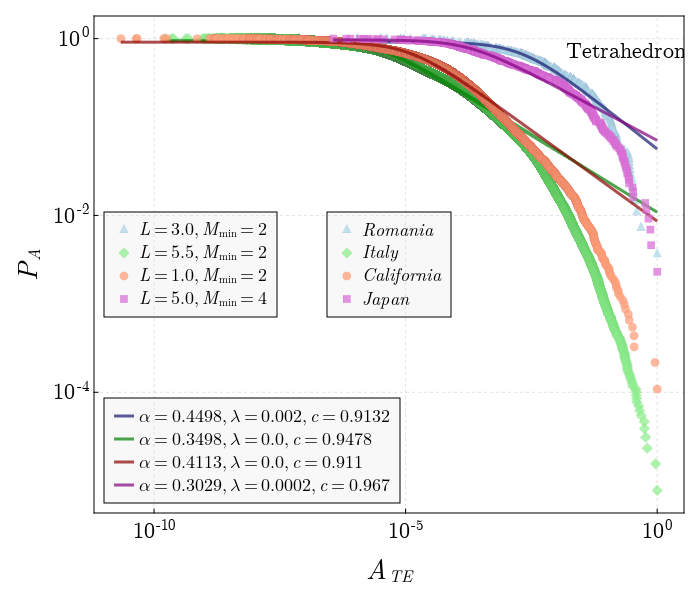

In [50]:
regions = ["Romania", "Italy", "California", "Japan"]
cell_sizes = [3.0, 5.5, 1.0, 5.0]
minimum_magnitudes = [2, 2, 2, 4]

results = [] 

set_theme!(Theme(fonts=(; regular="CMU Serif")))

markers=[:utriangle, :diamond, :circle, :rect]
colors=[:lightblue, :lightgreen, :lightsalmon, :orchid]
line_colors=[:midnightblue, :green, :darkred, :purple]

########################################### ALL
# CCDF of all data scattered 
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1,1], xlabel = L"A_{TE}", ylabel = L"P_A", xscale=log10, yscale=log10, ylabelsize = 28,
    xlabelsize = 28, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10, xticklabelsize=22, yticklabelsize=22)

sc = Array{Any,1}(undef,4)

for i in eachindex(regions)
    region = regions[i]
    cell_size = cell_sizes[i]
    minimum_magnitude = minimum_magnitudes[i]

    # Read data
    path = "./data/"
    filepath = path * region * ".csv"
    df = CSV.read(filepath, DataFrame);

    if weighted_by == "totalenergy"
        weight_key = 1
    else 
        weight_key = 2
    end
    
    #############################################################################################################################################################
    # Filter by magnitude
    df_filtered = df[df.Magnitude .> minimum_magnitude,:] 
    # Split into cubes
    df_filtered, df_filtered_cubes = region_cube_split(df_filtered,cell_size=cell_size, energyRelease=true);

    # Get the motif
    network_target_path = "./networks/$(region)/cell_size_$(string(cell_size))km/"
    motif_filename = "motif$(motif)_$(region)_cell_size_$(string(cell_size))km_minmag_$(string(minimum_magnitude)).csv"
    motifs = readdlm(network_target_path * motif_filename, ',', Int64);

    # Energy and areas calculator
    motif_energy = total_mean_energy(motifs, df_filtered, df_filtered_cubes);
    areas = area_triangles(motifs, df_filtered_cubes);

    # Area weighted by total/mean energy
    area_weight = []
    for key in keys(motif_energy)
        # Used to filter out zeros and very small areas (triangles on the vertical for example)
        if areas[key] > 1
            push!(area_weight, areas[key]/motif_energy[key][weight_key])
        end
    end

    x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(area_weight)
    # rescale
    x_ccdf_original_data = x_ccdf_original_data ./ maximum(x_ccdf_original_data)
    push!(results, [x_ccdf_original_data, y_ccdf_original_data])
    
    # y_ccdf_original_data = rescale_data(y_ccdf_original_data)

    popt_tsallis, pcov_tsallis = so.curve_fit(fit_tsallis((x, α, λ, c)->tsallis_ccdf(x, α, λ, c)), x_ccdf_original_data, y_ccdf_original_data, bounds=(0, Inf), maxfev=3000)

    alpha = round(popt_tsallis[1], digits=4)
    lambda = round(popt_tsallis[2], digits=4)
    c = round(popt_tsallis[3], digits=4)
    println("alpha= ", popt_tsallis[1],"\nlambda= ", popt_tsallis[2], "\nc= ", popt_tsallis[3])
    
    #############################################################################################################################################################
    # THE PLOTS 
    # CCDF of truncated data (fitted), x and y values

    sc[i] = scatter!(ax1, x_ccdf_original_data, y_ccdf_original_data,
    color=(colors[i], 0.75), strokewidth=0.05, strokecolor=(line_colors[i], 0.8), marker=markers[i], markersize=12)


    lines!(ax1, x_ccdf_original_data, tsallis_ccdf(x_ccdf_original_data, popt_tsallis[1], popt_tsallis[2], popt_tsallis[3]), label= L"\alpha=%$(alpha),\, \lambda=%$(lambda),\, c=%$(c)",
    color=(line_colors[i], 0.7), linewidth=3)

end

text!(ax1, motif, space = :relative, position = Point2f(0.8, 0.9), fontsize=22)


# AXIS LEGEND
axislegend(ax1, [sc[i] for i in eachindex(regions)], [L"%$(regions[i])" for i in eachindex(regions)],
position = :cc, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

axislegend(ax1, [sc[i] for i in eachindex(regions)], [L"L=%$(cell_sizes[i]), \, M_\mathrm{min}=%$(minimum_magnitudes[i])" for i in eachindex(regions)],
position = :lc, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

# axislegend(ax1, [sc[i] for i in eachindex(regions)], [L"%$(regions[i]), \, L=%$(cell_sizes[i]), \, M_\mathrm{min}=%$(minimum_magnitudes[i])" for i in eachindex(regions)],
# position = :lc, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

axislegend(ax1, position = :lb, bgcolor = (:grey90, 0.25), labelsize=18);

save("./motifs_selected_plots/tsallis/$(motif)_all_regions_rescaled.png", fig, px_per_unit=7)
fig



In [60]:
for i in eachindex(regions)
    restults_dataframe = DataFrame([results[i][1], results[i][2]], ["x","y"])
    CSV.write("./motifs_selected_plots/tsallis/$(regions[i])_result.csv", restults_dataframe, delim=",", header=true); 
end

In [48]:
motif = "Tetrahedron"
weighted_by = "totalenergy"

# Make path for plot results
mkpath("./motifs_selected_plots/tsallis/")

"./motifs_selected_plots/tsallis"

alpha= 0.22939579563760834
lambda= 1.3035083885017662e-5
c= 0.9251815529197258


alpha= 0.32872461220233073
lambda= 5.3663724354187e-6
c= 0.9646935065050156


alpha= 0.3921730130938499
lambda= 9.941309352694317e-7
c= 0.9754833432961787


alpha= 0.26819851904453457
lambda= 6.306980436311087e-9
c= 0.9646874065321553

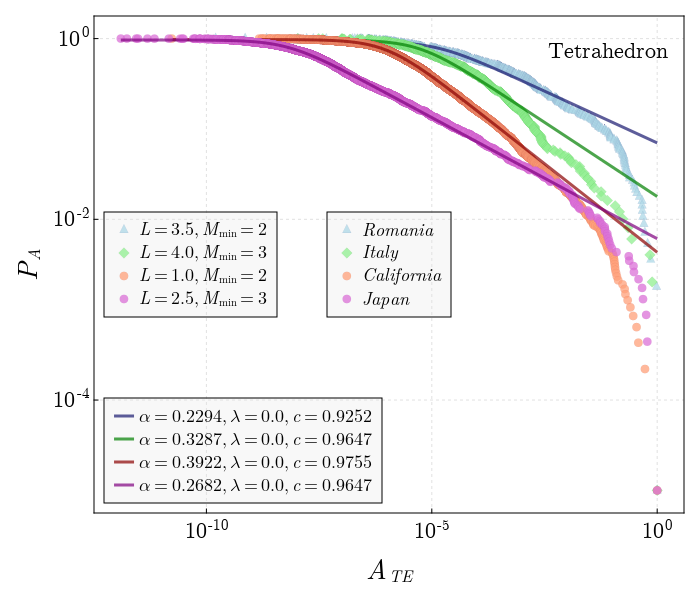

In [49]:
regions = ["Romania", "Italy", "California", "Japan"]
cell_sizes = [3.5, 4.0, 1.0, 2.5]
minimum_magnitudes = [2, 3, 2, 3]


set_theme!(Theme(fonts=(; regular="CMU Serif")))

markers=[:utriangle, :diamond, :circle, :circle]
colors=[:lightblue, :lightgreen, :lightsalmon, :orchid]
line_colors=[:midnightblue, :green, :darkred, :purple]

########################################### ALL
# CCDF of all data scattered 
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1,1], xlabel = L"A_{TE}", ylabel = L"P_A", xscale=log10, yscale=log10, ylabelsize = 28,
    xlabelsize = 28, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10, xticklabelsize=22, yticklabelsize=22)

sc = Array{Any,1}(undef,4)

for i in eachindex(regions)
    region = regions[i]
    cell_size = cell_sizes[i]
    minimum_magnitude = minimum_magnitudes[i]

    # Read data|
    path = "./data/"
    filepath = path * region * ".csv"
    df = CSV.read(filepath, DataFrame);

    if weighted_by == "totalenergy"
        weight_key = 1
    else 
        weight_key = 2
    end
    
    #############################################################################################################################################################
    # Filter by magnitude
    df_filtered = df[df.Magnitude .> minimum_magnitude,:] 
    # Split into cubes
    df_filtered, df_filtered_cubes = region_cube_split(df_filtered,cell_size=cell_size, energyRelease=true);

    # Get the motif
    network_target_path = "./networks/$(region)/cell_size_$(string(cell_size))km/"
    motif_filename = "motif$(motif)_$(region)_cell_size_$(string(cell_size))km_minmag_$(string(minimum_magnitude)).csv"
    motifs = readdlm(network_target_path * motif_filename, ',', Int64);

    # Energy and volumes calculator
    motif_energy = total_mean_energy(motifs, df_filtered, df_filtered_cubes);
    volumes = volume_tetrahedrons(motifs, df_filtered_cubes);

    # Volumes weighted by total/mean energy
    volume_weight = []
    for key in keys(motif_energy)
        # Used to filter out zeros and very small volumes (triangles on the vertical for example)
        if volumes[key] > 1
            push!(volume_weight, volumes[key]/motif_energy[key][weight_key])
        end
    end

    x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(volume_weight)
    # rescale
    x_ccdf_original_data = x_ccdf_original_data ./ maximum(x_ccdf_original_data)
    y_ccdf_original_data = rescale_data(y_ccdf_original_data)

    popt_tsallis, pcov_tsallis = so.curve_fit(fit_tsallis((x, α, λ, c)->tsallis_ccdf(x, α, λ, c)), x_ccdf_original_data, y_ccdf_original_data, bounds=(0, Inf), maxfev=3000)

    alpha = round(popt_tsallis[1], digits=4)
    lambda = round(popt_tsallis[2], digits=4)
    c = round(popt_tsallis[3], digits=4)
    println("alpha= ", popt_tsallis[1],"\nlambda= ", popt_tsallis[2], "\nc= ", popt_tsallis[3])
    
    #############################################################################################################################################################
    # THE PLOTS 
    # CCDF of truncated data (fitted), x and y values

    sc[i] = scatter!(ax1, x_ccdf_original_data, y_ccdf_original_data,
    color=(colors[i], 0.75), strokewidth=0.05, strokecolor=(line_colors[i], 0.8), marker=markers[i], markersize=12)


    lines!(ax1, x_ccdf_original_data, tsallis_ccdf(x_ccdf_original_data, popt_tsallis[1], popt_tsallis[2], popt_tsallis[3]), label= L"\alpha=%$(alpha),\, \lambda=%$(lambda),\, c=%$(c)",
    color=(line_colors[i], 0.7), linewidth=3)

end

text!(ax1, motif, space = :relative, position = Point2f(0.77, 0.9), fontsize=22)


# AXIS LEGEND
axislegend(ax1, [sc[i] for i in eachindex(regions)], [L"%$(regions[i])" for i in eachindex(regions)],
position = :cc, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

axislegend(ax1, [sc[i] for i in eachindex(regions)], [L"L=%$(cell_sizes[i]), \, M_\mathrm{min}=%$(minimum_magnitudes[i])" for i in eachindex(regions)],
position = :lc, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

# axislegend(ax1, [sc[i] for i in eachindex(regions)], [L"%$(regions[i]), \, L=%$(cell_sizes[i]), \, M_\mathrm{min}=%$(minimum_magnitudes[i])" for i in eachindex(regions)],
# position = :lc, bgcolor = (:grey90, 0.25), labelsize=18, titlesize=18);

axislegend(ax1, position = :lb, bgcolor = (:grey90, 0.25), labelsize=18);

save("./motifs_selected_plots/tsallis/$(motif)_all_regions_rescaled.png", fig, px_per_unit=7)
fig

